# regression_part_1_linear_regression

## Data import and test

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer


#Martim added imports from week 8
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge

In [38]:
name_data_file="heart_failure_clinical_records_dataset"

data = pd.read_csv(f"../../raw_data/{name_data_file}.csv", na_values=["?"])

In [39]:
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


## Data Processing

In [51]:
# continuous and binary columns
continuous_cols = [
    "age",
    "creatinine_phosphokinase", 
    "ejection_fraction",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
]
binary_cols = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]

from what Godinho and Ribau discussed we don´t need a one out of k encoding

In [53]:
# Predictors and target
y = data["time"]
X = data.drop(columns=["time"])  # remove target

# Remove variable in study 
X = X.drop(columns=["DEATH_EVENT"])

## Log transform of CDK column

In [54]:
# Log-transform: creatinine_phosphokinase column
X["creatinine_phosphokinase"] = np.log1p(X["creatinine_phosphokinase"])

#### check data

In [55]:
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75.0,0,6.368187,0,20,1,265000.00,1.9,130,1,0
1,55.0,0,8.969796,0,38,0,263358.03,1.1,136,1,0
2,65.0,0,4.990433,0,20,0,162000.00,1.3,129,1,1
3,50.0,1,4.718499,0,20,0,210000.00,1.9,137,1,0
4,65.0,1,5.081404,1,20,0,327000.00,2.7,116,0,0
...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,4.127134,1,38,1,155000.00,1.1,143,1,1
295,55.0,0,7.507141,0,38,0,270000.00,1.2,139,0,0
296,45.0,0,7.630947,1,60,0,742000.00,0.8,138,0,0
297,45.0,0,7.789040,0,38,0,140000.00,1.4,140,1,1


## Regularization parameter λ and Generalization Error

===== 10-fold CV (Ridge) — continuous-only scaling =====
     lambda  train_mse_mean  train_mse_std  gen_mse_est  test_mse_std
   0.000100     5268.966820     154.341549  5754.331618   1460.483575
   0.000174     5268.966820     154.341549  5754.331179   1460.483169
   0.000304     5268.966820     154.341549  5754.330414   1460.482460
   0.000530     5268.966820     154.341549  5754.329080   1460.481225
   0.000924     5268.966820     154.341549  5754.326756   1460.479071
   0.001610     5268.966820     154.341549  5754.322703   1460.475317
   0.002807     5268.966820     154.341549  5754.315639   1460.468772
   0.004894     5268.966822     154.341549  5754.303325   1460.457363
   0.008532     5268.966826     154.341549  5754.281863   1460.437475
   0.014874     5268.966838     154.341548  5754.244460   1460.402809
   0.025929     5268.966875     154.341547  5754.179298   1460.342391
   0.045204     5268.966988     154.341541  5754.065827   1460.237113
   0.078805     5268.967330     1

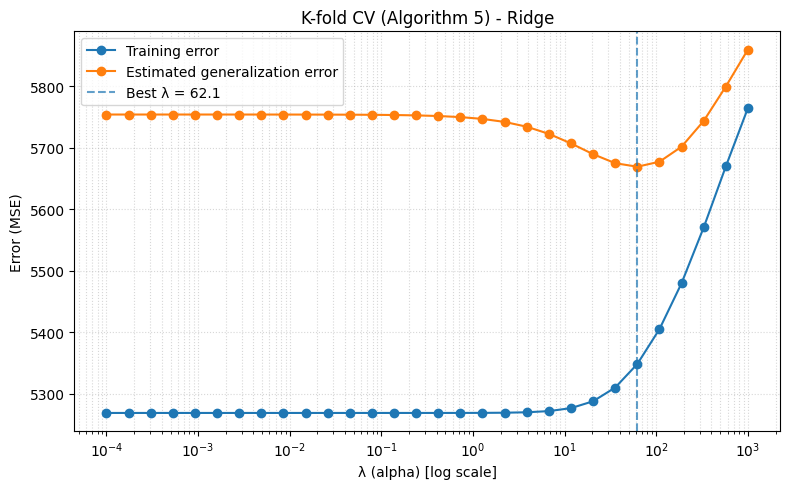


===== Coefficients (best λ model, standardized scale) =====
                 feature  coef_std_scale
     high_blood_pressure      -15.255043
                     age      -12.177509
                 anaemia       -9.632533
        serum_creatinine       -7.004276
            serum_sodium        4.006892
creatinine_phosphokinase        3.824699
       ejection_fraction        3.053731
                 smoking       -2.340475
                diabetes        1.065216
                     sex       -0.681022
               platelets       -0.468714


In [ ]:
# Cross-validation and model-selection hyperparameters (Algorithm 5)
K = 10  # number of folds
kf = KFold(n_splits=K, shuffle=True, random_state=42)
lambdas = np.logspace(-4, 3, 30)   # search range for λ - coloquei o da aula prática mas o valor de lambda ótimo pode não estar aqui, porque se alterarmos os valores, este altera tmb

# Containers for storing fold-aggregated results for each λ
train_err_mean, train_err_std = [], []
gen_err_est, test_err_std = [], []
N_total = len(X)

# Standardization of the train data (only continuous features)
def standardize_continuous(X_train_df, X_test_df, cont_cols):
    X_train_std = X_train_df.copy()
    X_test_std  = X_test_df.copy()

    # Ensure float dtype for continuous columns
    X_train_std[cont_cols] = X_train_std[cont_cols].astype("float64")
    X_test_std[cont_cols]  = X_test_std[cont_cols].astype("float64")

    # Compute mean and std from TRAIN fold
    mu = X_train_std[cont_cols].mean(axis=0)
    sigma = X_train_std[cont_cols].std(axis=0, ddof=0).replace(0, 1.0)

    # Apply z-score standardization
    X_train_std.loc[:, cont_cols] = (X_train_std[cont_cols] - mu) / sigma
    X_test_std.loc[:, cont_cols]  = (X_test_std[cont_cols]  - mu) / sigma

    return X_train_std, X_test_std


# Algorithm 5: for each λ, 10 K folds
# 'How does K-fold cross-validation work?
    # For each λ:
    #   For k = 1..K:
    #     - Split data into D_train^k and D_test^k
    #     - Fit model on D_train^k and compute test error on D_test^k
    #   Aggregate fold test errors to estimate generalization error of that λ
for lam in lambdas:
    fold_train_errs, fold_test_errs, fold_weights = [], [], []

    for train_idx, test_idx in kf.split(X, y):
        X_train = X.iloc[train_idx].copy()
        y_train = y.iloc[train_idx].copy()
        X_test  = X.iloc[test_idx].copy()
        y_test  = y.iloc[test_idx].copy()

        # Standardize continuous columns using TRAIN-fold stats (train model step in Algorithm 5)
        X_train, X_test = standardize_continuous(X_train, X_test, continuous_cols)

        # Define and fit Ridge with the λ at the moemnt
        model = Ridge(alpha=lam, random_state=42)
        model.fit(X_train, y_train)

        # Compute fold training and test errors (MSE) 
        y_pred_train = model.predict(X_train)
        y_pred_test  = model.predict(X_test)
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test  = mean_squared_error(y_test,  y_pred_test)

        fold_train_errs.append(mse_train)
        fold_test_errs.append(mse_test)
        fold_weights.append(len(test_idx) / N_total)

    # Store mean and std stats for this λ 
    train_err_mean.append(np.mean(fold_train_errs))
    train_err_std.append(np.std(fold_train_errs, ddof=1))
    gen_err_est.append(float(np.sum(np.array(fold_weights) * np.array(fold_test_errs))))
    test_err_std.append(np.std(fold_test_errs, ddof=1))

# Gather results in a table
cv_table = pd.DataFrame({
    "lambda": lambdas,
    "train_mse_mean": train_err_mean,
    "train_mse_std": train_err_std,
    "gen_mse_est": gen_err_est,
    "test_mse_std": test_err_std,
})

# Pick the λ with the lowest estimated generalization error
best_idx = int(np.argmin(cv_table["gen_mse_est"].values)) 
best_lambda = float(cv_table.loc[best_idx, "lambda"])
best_gen_mse = float(cv_table.loc[best_idx, "gen_mse_est"])

print("===== 10-fold CV (Ridge) — continuous-only scaling =====")
print(cv_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))
print(f"\nBest λ (alpha): {best_lambda:.6g}")
print(f"Estimated generalization error (MSE): {best_gen_mse:.6f}")

# Plot: training error vs. estimated generalization error (as in the lecture figure)
plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, cv_table["train_mse_mean"], marker="o", label="Training error")
plt.semilogx(lambdas, cv_table["gen_mse_est"],  marker="o", label="Estimated generalization error")
plt.axvline(best_lambda, linestyle="--", alpha=0.7, label=f"Best λ = {best_lambda:.3g}")
plt.xlabel("λ (alpha) [log scale]")
plt.ylabel("Error (MSE)")
plt.title("K-fold CV (Algorithm 5) - Ridge")
plt.legend()
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.tight_layout()
plt.show()

# Final model fit on the FULL dataset (for point 3 of part 1-A) 
# Standardize continuous columns using FULL-data stats, then refit with best λ
mu_full = X[continuous_cols].mean(axis=0)
sigma_full = X[continuous_cols].std(axis=0, ddof=0).replace(0, 1.0)

# Work only on X_std_full and cast continuous cols to float BEFORE computing stats
X_std_full = X.copy()
X_std_full[continuous_cols] = X_std_full[continuous_cols].astype("float64")

# Compute scaling stats from FULL data (on float cols)
mu_full = X_std_full[continuous_cols].mean(axis=0)
sigma_full = X_std_full[continuous_cols].std(axis=0, ddof=0).replace(0, 1.0)

# Apply z-score using FULL-data stats (note: use X_std_full on both sides)
X_std_full.loc[:, continuous_cols] = (X_std_full[continuous_cols] - mu_full) / sigma_full

# Fit final ridge with best λ
best_model = Ridge(alpha=best_lambda, random_state=42)
best_model.fit(X_std_full, y)

coef_table = pd.DataFrame({
    "feature": X_std_full.columns,
    "coef_std_scale": best_model.coef_
}).sort_values("coef_std_scale", key=np.abs, ascending=False)

print("\n===== Coefficients (best λ model, standardized scale) =====")
print(coef_table.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

#### check data

In [59]:
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75.0,0,6.368187,0,20,1,265000.00,1.9,130,1,0
1,55.0,0,8.969796,0,38,0,263358.03,1.1,136,1,0
2,65.0,0,4.990433,0,20,0,162000.00,1.3,129,1,1
3,50.0,1,4.718499,0,20,0,210000.00,1.9,137,1,0
4,65.0,1,5.081404,1,20,0,327000.00,2.7,116,0,0
...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,4.127134,1,38,1,155000.00,1.1,143,1,1
295,55.0,0,7.507141,0,38,0,270000.00,1.2,139,0,0
296,45.0,0,7.630947,1,60,0,742000.00,0.8,138,0,0
297,45.0,0,7.789040,0,38,0,140000.00,1.4,140,1,1


pipeline for this is in class 8